In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import math
import time
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,mean_absolute_error
import datetime
import operator
plt.style.use('seaborn')
%matplotlib inline


In [4]:
#read dataset
confirmed_cases = pd.read_csv(r'..\covid-19\novel-corona-virus-2019-dataset\time_series_covid_19_confirmed.csv')
death_reported = pd.read_csv(r'..\covid-19\novel-corona-virus-2019-dataset\time_series_covid_19_deaths.csv')
recovered_cases = pd.read_csv(r'..\covid-19\novel-corona-virus-2019-dataset\time_series_covid_19_recovered.csv')


In [5]:
confirmed_cases.head()


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,3392,3563,3778,4033,4402,4687,4963,5226,5639,6053
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,832,842,850,856,868,872,876,880,898,916
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,4997,5182,5369,5558,5723,5891,6067,6253,6442,6629
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,751,752,752,754,755,755,758,760,761,761
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,36,36,43,43,45,45,45,45,48,48


In [6]:
death_reported.head()


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,104,106,109,115,120,122,127,132,136,153
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,31,31,31,31,31,31,31,31,31,31
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,476,483,488,494,502,507,515,522,529,536
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,46,47,47,48,48,48,48,49,49,49
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


In [7]:
recovered_cases.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,458,468,472,502,558,558,610,648,691,745
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,595,605,620,627,650,654,682,688,694,705
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,2197,2323,2467,2546,2678,2841,2998,3058,3158,3271
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,521,526,537,545,550,550,568,576,596,604
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,11,11,11,13,13,13,13,14,14,17


In [8]:
col = confirmed_cases.keys()

In [9]:
confirmed = confirmed_cases.loc[:,col[4]:col[-1]]

In [10]:
deaths = death_reported.loc[:,col[4]:col[-1]]

In [11]:
recovered = recovered_cases.loc[:,col[4]:col[-1]]

In [12]:
#finding total cases, deaths and mortality rate
dates = confirmed.keys()
world_cases = []
total_deaths = []
mortality_rate = []
total_recovered = []
for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recovered[i].sum()
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    mortality_rate.append(death_sum/confirmed_sum)
    total_recovered.append(recovered_sum)


In [13]:
#convert cases and days in array
days = np.array([i for i in range(len(dates))]).reshape(-1,1)
world_cases = np.array(world_cases).reshape(-1,1)
total_deaths = np.array(total_deaths).reshape(-1,1)
total_recovered = np.array(total_recovered).reshape(-1,1)


In [14]:
#future forcasting for next 10 days
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1,1)
adjusted_dates = future_forcast[:-10]

In [15]:
#convert all integers into dates
start = "1/22/2020"
start_date = datetime.datetime.strptime(start,"%m/%d/%Y")
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime("%m/%d/%Y"))
    

In [16]:
latest_confirmed = confirmed_cases[dates[-1]]
latest_deaths = death_reported[dates[-1]]
latest_recovered = recovered_cases[dates[-1]]

In [17]:
unique_counteries = list(confirmed_cases['Country/Region'].unique())

In [18]:
#total number of cases by each country
country_confirmed_cases = []
no_cases = []
for i in unique_counteries:
    cases = latest_confirmed[confirmed_cases['Country/Region']==i].sum()
    if cases>0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
    
for i in no_cases:
    unique_counteries.remove(i)
    
unique_counteries = [k for k,v in sorted(zip(unique_counteries,country_confirmed_cases),key=operator.itemgetter(1),reverse=True)]  
for i in range(len(unique_counteries)):
    country_confirmed_cases[i] = latest_confirmed[confirmed_cases['Country/Region']==unique_counteries[i]].sum()
    

In [19]:
#number of cases per country/region
print("Confirmed cases per Country/Region")
for i in range(len(unique_counteries)):
    print(f'{unique_counteries[i]}:{country_confirmed_cases[i]} cases')

Confirmed cases per Country/Region
US:1442824 cases
Russia:262843 cases
United Kingdom:238004 cases
Spain:230183 cases
Italy:223885 cases
Brazil:220291 cases
France:179630 cases
Germany:175233 cases
Turkey:146457 cases
Iran:116635 cases
India:85784 cases
Peru:84495 cases
China:84038 cases
Canada:75959 cases
Belgium:54644 cases
Saudi Arabia:49176 cases
Mexico:45032 cases
Netherlands:43880 cases
Chile:39542 cases
Pakistan:38799 cases
Ecuador:31467 cases
Switzerland:30514 cases
Qatar:29425 cases
Sweden:29207 cases
Portugal:28583 cases
Belarus:27730 cases
Singapore:26891 cases
Ireland:23956 cases
United Arab Emirates:21831 cases
Bangladesh:20065 cases
Poland:18016 cases
Ukraine:17330 cases
Israel:16589 cases
Indonesia:16496 cases
Romania:16437 cases
Japan:16203 cases
Austria:16109 cases
Colombia:14216 cases
South Africa:13524 cases
Kuwait:12860 cases
Philippines:12091 cases
Dominican Republic:11739 cases
Egypt:11228 cases
Korea, South:11037 cases
Denmark:10989 cases
Serbia:10438 cases
Pana

In [20]:
#find the list of unique provinces
unique_provinces = list(confirmed_cases['Province/State'].unique())
outliers = ['United Kingdom','Denmark','France']
for i in outliers:
    if i in unique_provinces:
        unique_provinces.remove(i)        

In [21]:
#total number of cases by each country
province_confirmed_cases = []
no_cases = []
for i in unique_provinces:
    cases = latest_confirmed[confirmed_cases['Province/State']==i].sum()
    if cases>0:
        province_confirmed_cases.append(cases)
    else:
        no_cases.append(i)    
for i in no_cases:
    unique_provinces.remove(i)
    

In [22]:
#number of cases per country/region
print("Confirmed cases per Province/State")
for i in range(len(unique_provinces)):
    print(f'{unique_provinces[i]}:{province_confirmed_cases[i]} cases')

Confirmed cases per Province/State
Australian Capital Territory:107 cases
New South Wales:3074 cases
Northern Territory:29 cases
Queensland:1055 cases
South Australia:439 cases
Tasmania:228 cases
Victoria:1551 cases
Western Australia:552 cases
Alberta:6515 cases
British Columbia:2407 cases
Grand Princess:13 cases
Manitoba:289 cases
New Brunswick:120 cases
Newfoundland and Labrador:260 cases
Nova Scotia:1034 cases
Ontario:23258 cases
Prince Edward Island:27 cases
Quebec:41429 cases
Saskatchewan:590 cases
Anhui:991 cases
Beijing:593 cases
Chongqing:579 cases
Fujian:356 cases
Gansu:139 cases
Guangdong:1589 cases
Guangxi:254 cases
Guizhou:147 cases
Hainan:169 cases
Hebei:328 cases
Heilongjiang:945 cases
Henan:1276 cases
Hong Kong:1052 cases
Hubei:68134 cases
Hunan:1019 cases
Inner Mongolia:209 cases
Jiangsu:653 cases
Jiangxi:937 cases
Jilin:140 cases
Liaoning:149 cases
Macau:45 cases
Ningxia:75 cases
Qinghai:18 cases
Shaanxi:308 cases
Shandong:788 cases
Shanghai:665 cases
Shanxi:198 cases


In [23]:
#handeling naN values
nan_indices = []
for i in range(len(unique_provinces)):
    if(unique_provinces[i]=='NaN'):
       nan_indices.append(i)
unique_provinces = list(unique_provinces)
province_confirmed_cases = list(province_confirmed_cases)
    

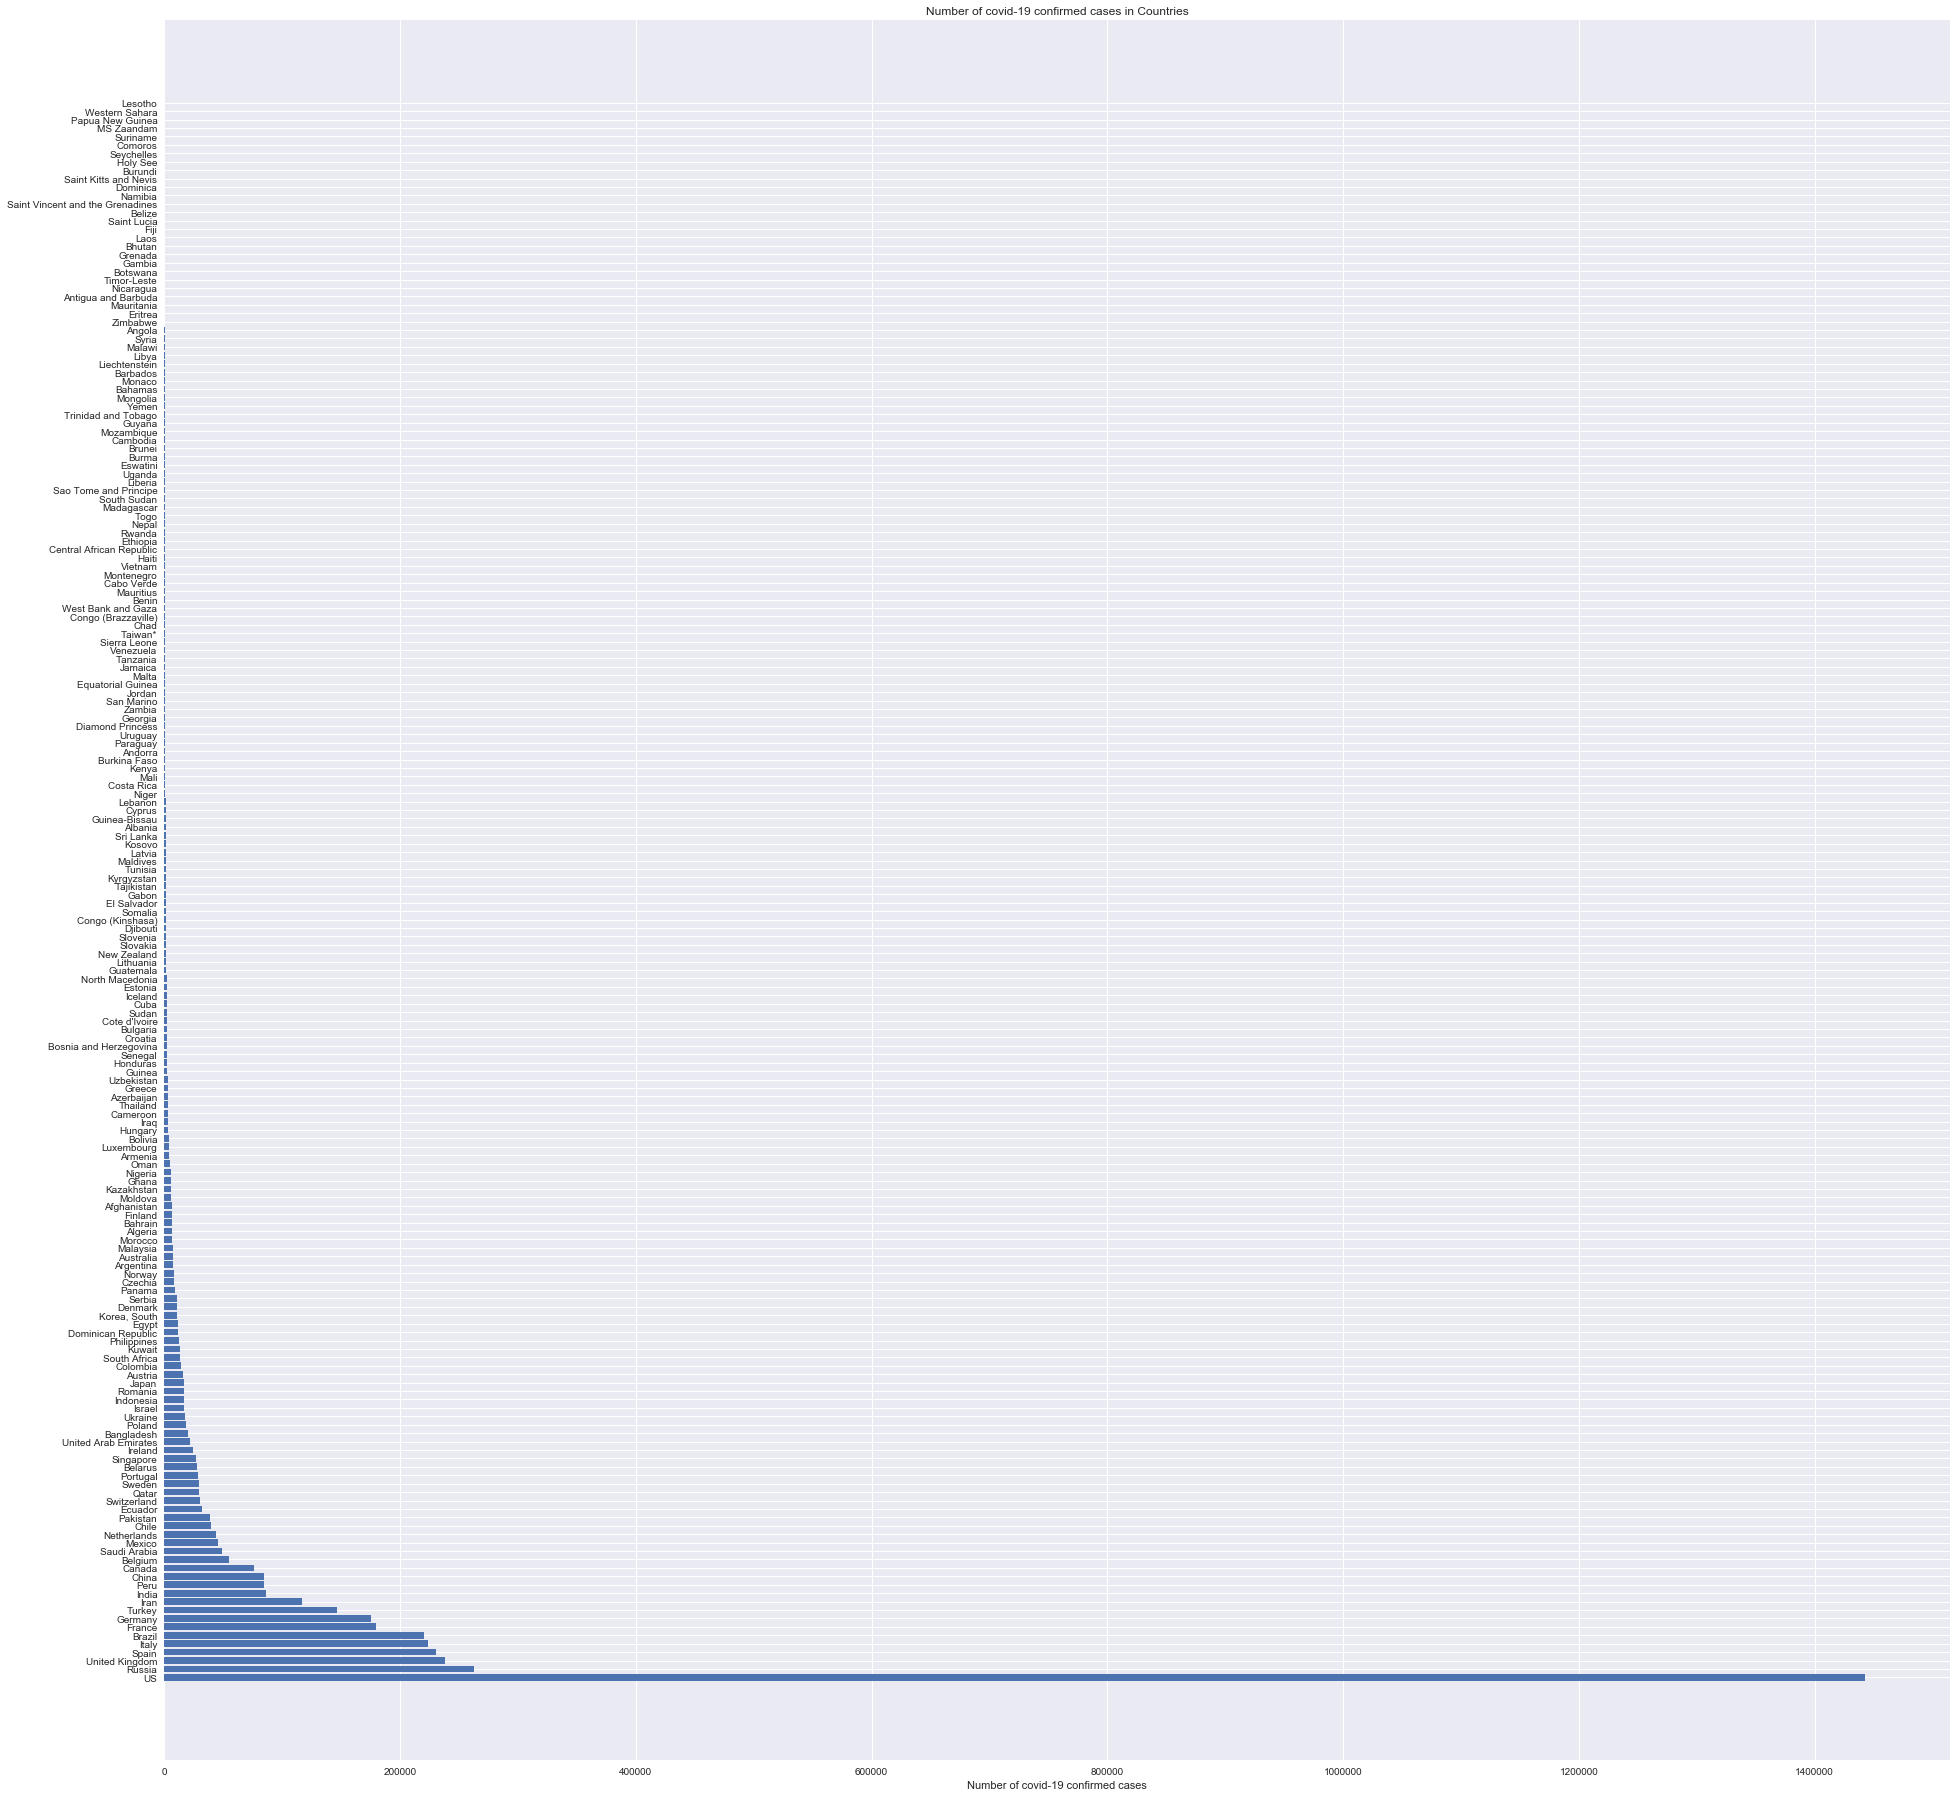

In [24]:
#plot a bar graph to see the total confirmed cases across different counteries
plt.figure(figsize=(32,32))
plt.barh(unique_counteries,country_confirmed_cases)
plt.title("Number of covid-19 confirmed cases in Countries")
plt.xlabel("Number of covid-19 confirmed cases")
plt.show()

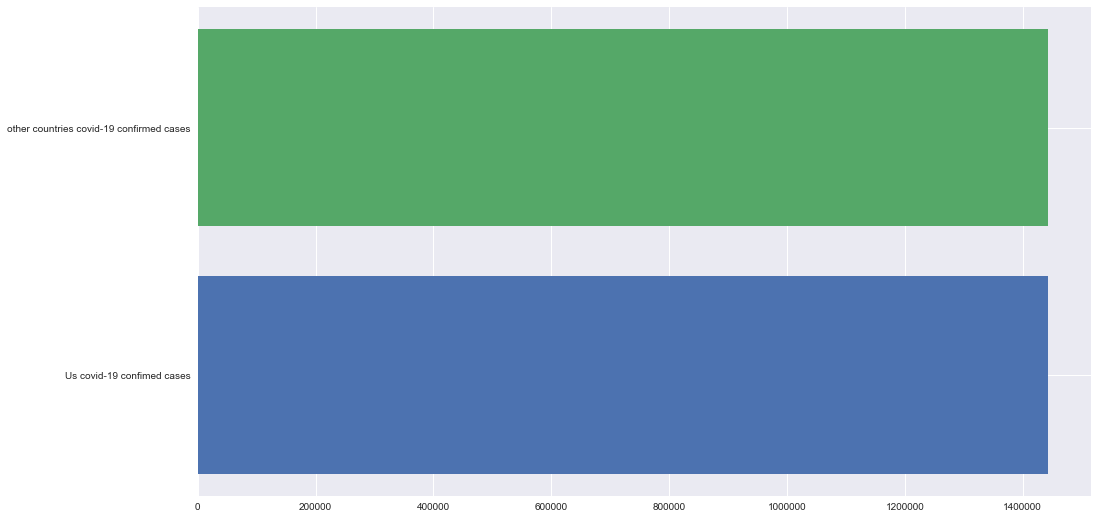

In [25]:
# Compare confirmed covid-19 cases between and Us and other countries
confirmed_us = latest_confirmed[confirmed_cases["Country/Region"]=='US'].sum()
confirmed_non_us = np.sum(latest_confirmed)-confirmed_us
plt.figure(figsize=(16,9))
plt.barh("Us covid-19 confimed cases",confirmed_us)
plt.barh("other countries covid-19 confirmed cases",confirmed_us)

plt.show()

In [26]:
#only show 10 countries with the most covid-19 confirmed cases
top_countries = []
top_cases = []
others = np.sum(country_confirmed_cases[10:])
for i in range(len(country_confirmed_cases[:10])):
    top_countries.append(unique_counteries[i])
    top_cases.append(country_confirmed_cases[i])
top_countries.append('Others')    
top_cases.append(others)

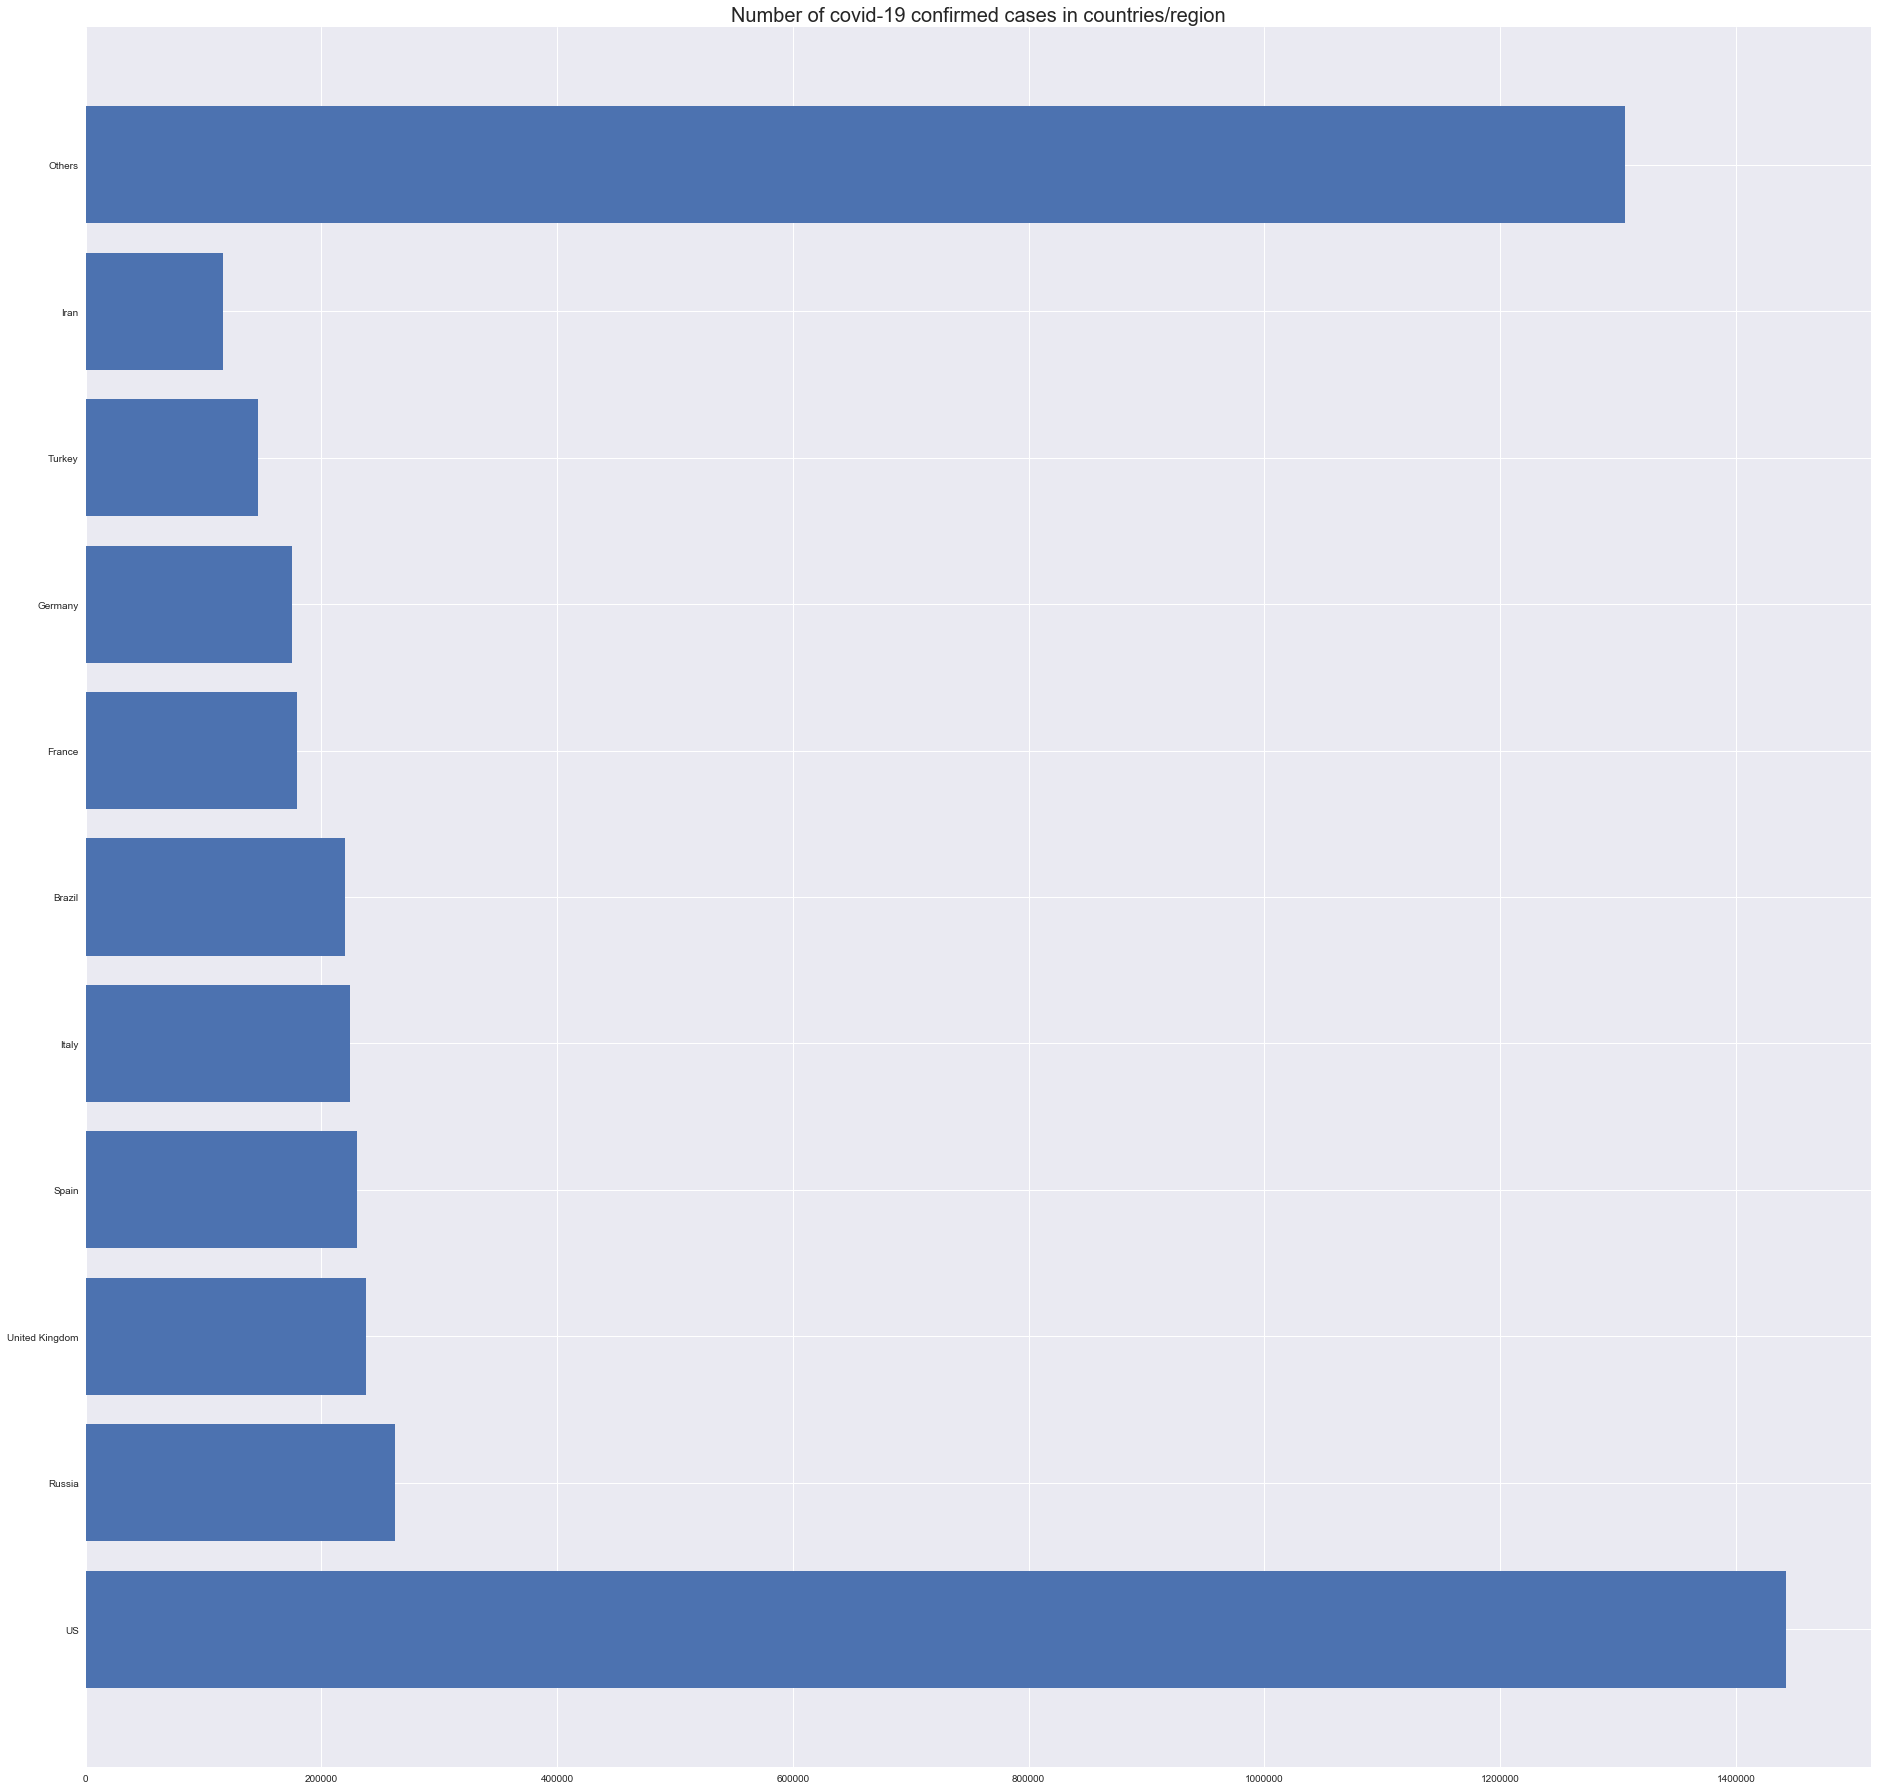

In [27]:
plt.figure(figsize=(32,32))
plt.barh(top_countries,top_cases)
plt.title("Number of covid-19 confirmed cases in countries/region",size=20)
plt.show()


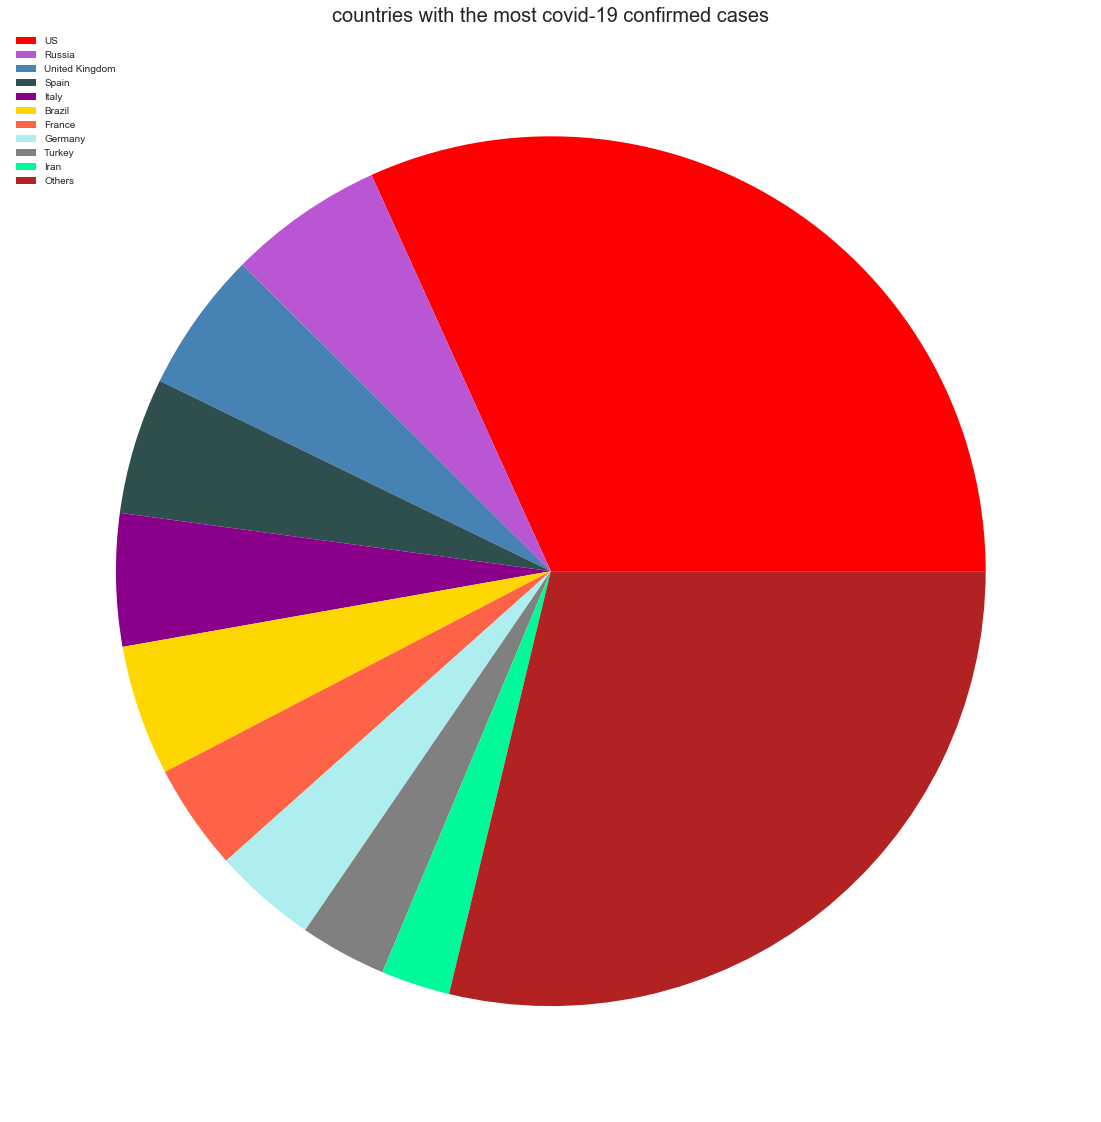

In [28]:
#create a pie chart for visualisation for top 10 countries with the most covid-19 confirmed cases
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_counteries))
plt.figure(figsize=(20,20))
plt.title("countries with the most covid-19 confirmed cases",size=20)
plt.pie(top_cases,colors=c)
plt.legend(top_countries,loc="best")
plt.show()


In [29]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days, world_cases, test_size=0.15, shuffle=False)

In [30]:
#building the svm model
kernel = ['poly','sigmoid','rbf']
c = [0.01,0.1]
gamma = [0.01,0.1,1]
epsilon = [0.01,0.1,1]
shrinking = [True,False]
svm_grid = {'kernel':kernel,'C':c,'gamma':gamma,'epsilon':epsilon,'shrinking':shrinking}
svm = SVR()
svm_search = RandomizedSearchCV(svm,svm_grid,scoring = 'neg_mean_squared_error',cv = 3,return_train_score = True,n_jobs = -1,n_iter=40,verbose=1)
svm_search.fit(X_train_confirmed,y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   47.8s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, shrinking=True,
                                 tol=0.001, verbose=False),
                   iid='warn', n_iter=40, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1],
                                        'epsilon': [0.01, 0.1, 1],
                                        'gamma': [0.01, 0.1, 1],
                                        'kernel': ['poly', 'sigmoid', 'rbf'],
                                        'shrinking': [True, False]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [31]:
svm_search.best_params_

{'shrinking': False, 'kernel': 'poly', 'gamma': 1, 'epsilon': 0.1, 'C': 0.1}

In [32]:
svm_confirmed = svm_search.best_estimator_
svm_pred = svm_confirmed.predict(future_forcast)

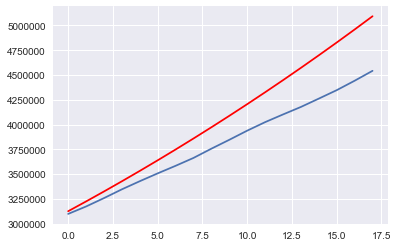

MAE: 254389.04225181634
MSE: 91469047209.04669


In [33]:
# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(svm_test_pred,color='red')
plt.plot(y_test_confirmed)
plt.show()
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))


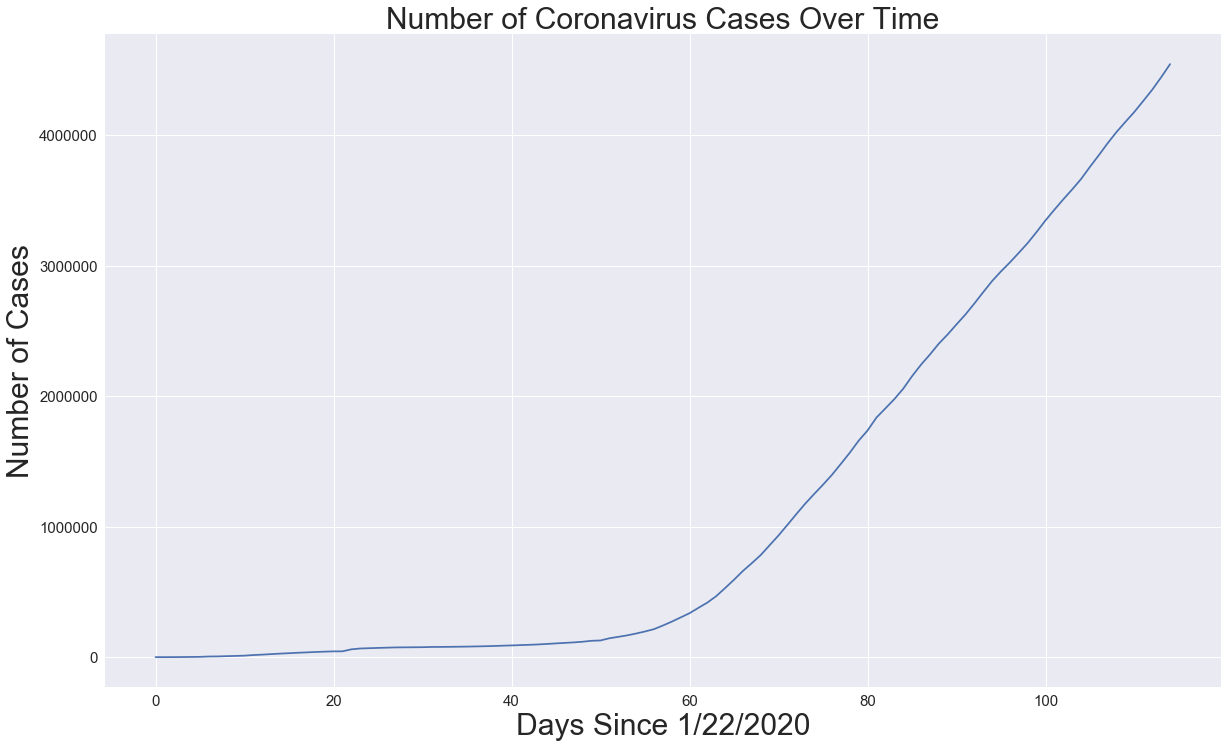

In [34]:
# Total number of coronavirus cases over time
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, world_cases)
plt.title('Number of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Number of Cases', size=30)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

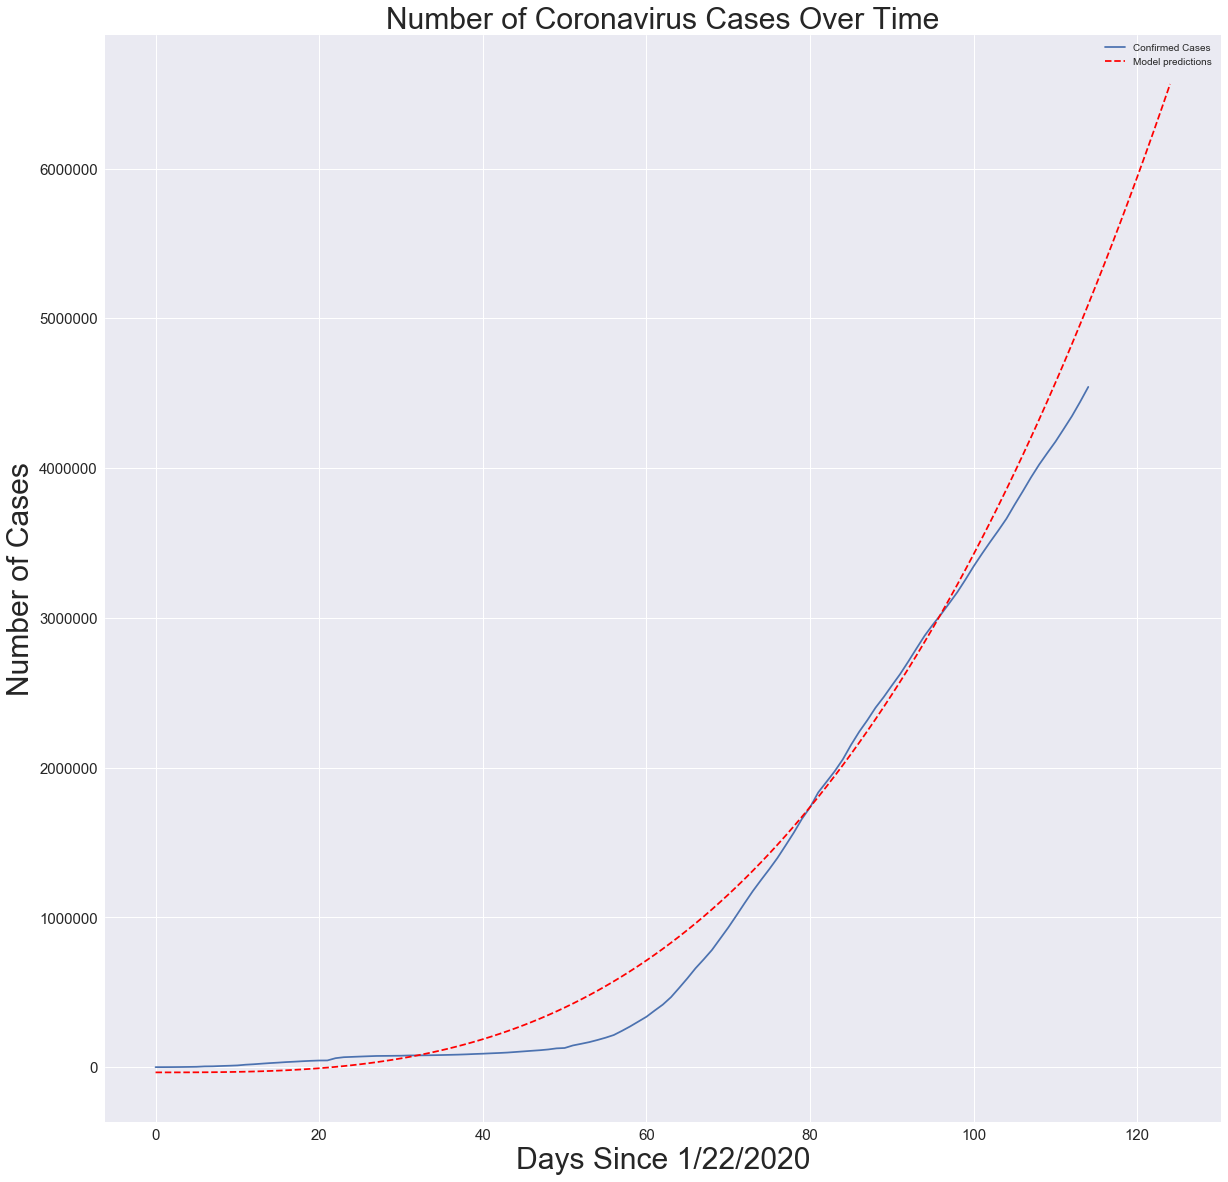

[-3.44583325e+04 -3.44548713e+04 -3.44306430e+04 -3.43648804e+04
 -3.42368164e+04 -3.40256839e+04 -3.37107157e+04 -3.32711447e+04
 -3.26862038e+04 -3.19351259e+04 -3.09971437e+04 -2.98514903e+04
 -2.84773983e+04 -2.68541008e+04 -2.49608306e+04 -2.27768205e+04
 -2.02813034e+04 -1.74535122e+04 -1.42726798e+04 -1.07180389e+04
 -6.76882260e+03 -2.40426360e+03  2.39640517e+03  7.65395087e+03
  1.33891406e+04  1.96227415e+04  2.63755207e+04  3.36682454e+04
  4.15216826e+04  4.99565996e+04  5.89937634e+04  6.86539411e+04
  7.89579000e+04  8.99264071e+04  1.01580230e+05  1.13940135e+05
  1.27026889e+05  1.40861261e+05  1.55464016e+05  1.70855922e+05
  1.87057747e+05  2.04090256e+05  2.21974219e+05  2.40730400e+05
  2.60379569e+05  2.80942491e+05  3.02439934e+05  3.24892666e+05
  3.48321452e+05  3.72747061e+05  3.98190259e+05  4.24671814e+05
  4.52212493e+05  4.80833063e+05  5.10554291e+05  5.41396943e+05
  5.73381788e+05  6.06529593e+05  6.40861124e+05  6.76397149e+05
  7.13158434e+05  7.51165

In [35]:
# Confirmed vs Predicted Cases
plt.figure(figsize=(20, 20))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast, svm_pred, linestyle='dashed', color='red')
plt.title('Number of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Number of Cases', size=30)
plt.legend(['Confirmed Cases', 'Model predictions'])
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()
print(svm_pred)